# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import activations
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D

# Import the Dataset

In [2]:
data = pd.read_csv("cleaned_text.csv", encoding='latin1', header = 0)
#data.columns = ["tweet", "sentiment"]
data

,Unnamed: 0,tweet,punctuation_count,sentiment
0,0,sleep good remedi fall asleep need one,6,0
1,1,work fun,2,0
2,2,summer person love dull cold weather centralco...,3,1
3,3,want smoke cig lighter,2,0
4,4,pass lot twit arriv trend topic bob,8,0
...,...,...,...,...
105236,105236,i i i i i miss trip hehe turn bird amp turtl l...,15,1
105237,105237,hump say,2,0
105238,105238,seriou chemistri revis feel rather ill atm,1,0
105239,105239,weekend go sound like time iphon poker girl let,5,0


# Preparing the Dataset

In [9]:
#Droping columnns we dont need for the NN model
data.drop(data.columns[[0]], axis=1, inplace=True)


In [10]:
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0


In [11]:
data.sentiment.value_counts() # dataset is already balanced

0    52657
1    52584
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='tweet', ylabel='count'>

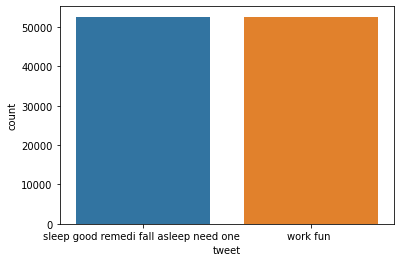

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(x = data.sentiment, data = data.tweet)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105241 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  105241 non-null  int64 
 2   sentiment          105241 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


In [13]:
data.dropna(subset = ["tweet"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104742 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  104742 non-null  int64 
 2   sentiment          104742 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


# Tokenize

In [14]:
#Keeping the labels and creating preparing text for tfidf vectorizer
Y = data[['sentiment']]
X = data.drop(['sentiment'], axis=1)
X.head()

,tweet,punctuation_count
0,sleep good remedi fall asleep need one,6
1,work fun,2
2,summer person love dull cold weather centralco...,3
3,want smoke cig lighter,2
4,pass lot twit arriv trend topic bob,8


In [15]:
tweet = X[['tweet']]
punctuation_counts = X[['punctuation_count']]

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words="english", max_features=10000)

tfidf_vect = vectorizer.fit_transform(X['tweet'])
tfidf_feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame (tfidf_vect.todense())
tfidf_df.columns = tfidf_feature_names
tfidf_df['punctuation_count'] = punctuation_counts

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection

min_max_scaler = preprocessing.MinMaxScaler()
tfidf_df['punctuation_count'] = min_max_scaler.fit_transform(punctuation_counts)

In [18]:
tfidf_df.shape

(104742, 10001)

# Split Data

In [19]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf_df,
                                                Y,
                                                test_size=0.2,
                                                random_state=10)

In [20]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((83793, 10001), (20949, 10001), (83793, 1), (20949, 1))

In [21]:
# size/shape of dataframe
n_samples = Xtrain.shape[0]
n_featuers = Xtrain.shape[1]

# Model 1

In [28]:
# Make the NN -----------------------------------------------------------------

# Importing the Keras libraries and packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model = keras.Sequential(
    [
        layers.Dense(10000, activation='relu', kernel_regularizer='l2', name='layer1'),
        layers.Dropout(0.5),
        layers.Dense(500, activation='relu', name='layer2'),
        layers.Dense(25, activation='relu', name='layer3'),
        layers.Dense(1, activation='sigmoid', name='output1'),
    ]
)

In [23]:
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0, clipvalue=0.5, name="Adam")

In [29]:
# Compiling the ANN
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [30]:
model_save_filename = "twitter_model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)


history = model.fit(
                    Xtrain, 
                    ytrain, 
                    batch_size=1000,
                    epochs=100, 
                    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
                    validation_data = (Xtest, ytest)
                    )

Epoch 1/100
84/84 [==============================] - 22s 215ms/step - loss: 7.5199 - accuracy: 0.6910 - val_loss: 0.8333 - val_accuracy: 0.7190
Epoch 2/100
84/84 [==============================] - 11s 127ms/step - loss: 0.8155 - accuracy: 0.7180 - val_loss: 0.7928 - val_accuracy: 0.7198
Epoch 3/100
84/84 [==============================] - 11s 131ms/step - loss: 0.7795 - accuracy: 0.7234 - val_loss: 0.7667 - val_accuracy: 0.7271
Epoch 4/100
84/84 [==============================] - 11s 127ms/step - loss: 0.7596 - accuracy: 0.7289 - val_loss: 0.7560 - val_accuracy: 0.7315
Epoch 5/100
84/84 [==============================] - 11s 128ms/step - loss: 0.7394 - accuracy: 0.7326 - val_loss: 0.7482 - val_accuracy: 0.7252
Epoch 6/100
84/84 [==============================] - 11s 127ms/step - loss: 0.7246 - accuracy: 0.7363 - val_loss: 0.7330 - val_accuracy: 0.7358
Epoch 7/100
84/84 [==============================] - 11s 128ms/step - loss: 0.7157 - accuracy: 0.7381 - val_loss: 0.7158 - val_accuracy:

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 10000)             100020000 
_________________________________________________________________
dropout_9 (Dropout)          (None, 10000)             0         
_________________________________________________________________
layer2 (Dense)               (None, 500)               5000500   
_________________________________________________________________
layer3 (Dense)               (None, 25)                12525     
_________________________________________________________________
output1 (Dense)              (None, 1)                 26        
Total params: 105,033,051
Trainable params: 105,033,051
Non-trainable params: 0
_________________________________________________________________


In [21]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [32]:
# Make predictions
# Predicting the Test set results
y_pred_train = model.predict(Xtrain)

In [33]:
# Predicting the Test set results
y_pred_test = model.predict(Xtest)

In [133]:
# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(ytest, y_pred_test)


In [34]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


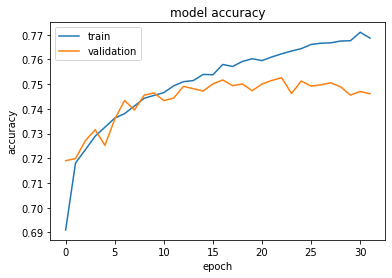

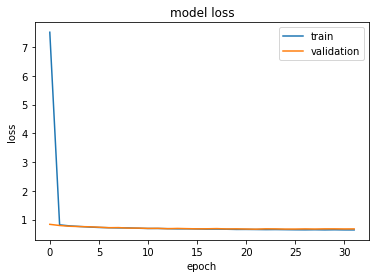

In [35]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Traditional ML Models

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [42]:
#Random Forest Classifier
RF = RandomForestClassifier(max_depth=10)
RF.fit(Xtrain, ytrain)
y_pred = RF.predict(Xtest)
cm3 = confusion_matrix(y_pred, ytest)
total3=sum(sum(cm3))
Accuracy = (cm3[0,0]+cm3[1,1])/total3
Specificity = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print("Accuracy of  RFC :", Accuracy, "--Specificity of  RFC :", Specificity )

C:\Users\Mike\AppData\Local\Temp/ipykernel_6980/693845353.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(Xtrain, ytrain)


Accuracy of  RFC : 0.721609623371044 --Specificity of  RFC : 0.7563220940550133


In [25]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(Xtrain, ytrain)
y_pred = model5.predict(Xtest)
cm5 = confusion_matrix(y_pred, ytest)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )

C:\Users\Mike\.conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of  GaussianNB : 0.6781707957420402 --Sensitivity of  GaussianNB : 0.6545080279950597 --Specificity of  GaussianNB : 0.7108132666969559


# Model 2

In [144]:
# Make the NN -----------------------------------------------------------------

# Importing the Keras libraries and packages
from keras.layers import Dense
from keras.models import Sequential

# define and initialize the model
my_classifier2 = Sequential()

# Adding the input layer AND the first hidden layer
my_classifier2.add(Dense(units = 40, kernel_initializer = 'uniform',
                        activation = 'relu', input_dim = n_featuers))

# Adding the second hidden layer
my_classifier2.add(Dense(units = 30, kernel_initializer = 'uniform',
                        activation = 'relu'))

# Adding the third hidden layer
my_classifier2.add(Dense(units = 15, kernel_initializer = 'uniform',
                        activation = 'relu'))


# Adding the last (output) layer
my_classifier2.add(Dense(units = 1, kernel_initializer = 'uniform',
                        activation = 'sigmoid'))

In [145]:
# Compiling the ANN
my_classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

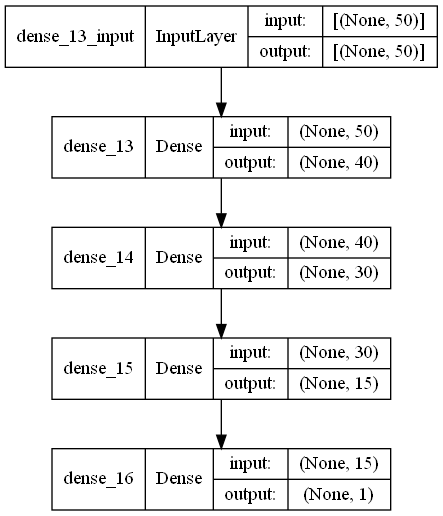

In [146]:
#-- plot the model
from keras.utils.vis_utils import plot_model
plot_model(my_classifier2, to_file='model2.png', show_shapes=True)

In [147]:
# Fitting the ANN to the Training set
history = my_classifier2.fit(Xtrain, ytrain, validation_split=0.2,
                            batch_size = 10, epochs = 60)

Epoch 1/60
6736/6736 [==============================] - 6s 905us/step - loss: 0.6936 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 2/60
6736/6736 [==============================] - 6s 872us/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 3/60
6736/6736 [==============================] - 6s 860us/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 4/60
6736/6736 [==============================] - 6s 864us/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.4970
Epoch 5/60
6736/6736 [==============================] - 6s 878us/step - loss: 0.6928 - accuracy: 0.5013 - val_loss: 0.7029 - val_accuracy: 0.5101
Epoch 6/60
6736/6736 [==============================] - 5s 803us/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6929 - val_accuracy: 0.4970
Epoch 7/60
6736/6736 [==============================] - 9s 1ms/step - loss: 0.6928 - accuracy: 0.5030 - val_loss: 0.6932 - v

In [151]:
my_classifier2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 40)                2040      
                                                                 
 dense_14 (Dense)            (None, 30)                1230      
                                                                 
 dense_15 (Dense)            (None, 15)                465       
                                                                 
 dense_16 (Dense)            (None, 1)                 16        
                                                                 
Total params: 3,751
Trainable params: 3,751
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Make predictions
# Predicting the Test set results
y_pred_train = my_classifier2.predict(Xtrain)

In [149]:
# Predicting the Test set results
y_pred_test = my_classifier2.predict(Xtest)

In [ ]:
# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(ytest, y_pred_test)


In [150]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


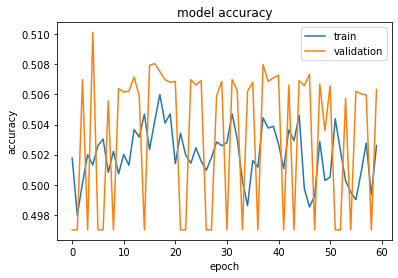

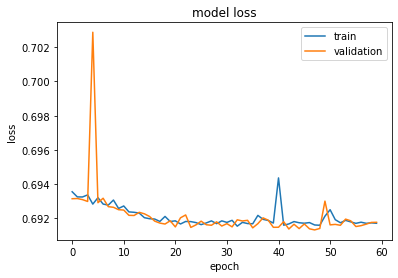

In [153]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()